# Applying Zipf's law to *el país* collection

Let's apply Zipf's law to a collection put together by scraping the news site *el país*. The code used to create the collection and the data used in this notebook can be found at this [notebook's repository](https://github.com/Benardi/bochica).

In [1]:
from math import log10
import re

#import nltk
#nltk.download('punkt')
#nltk.download('stopwords')

import pandas as pd
from plotnine import *
from numpy import arange
from nltk.util import ngrams    
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize, stem
from IPython.display import Markdown, HTML, display

%matplotlib inline
default_stopwords = set(stopwords.words('portuguese'))

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Load Data

In [3]:
data = pd.read_csv("../output/results.csv")
data.head()

,title,subtitle,author,date,section,text,url
0,“A sociedade foi Rubens Paiva não os facínora...,A decisão da juíza que proíbe as Forças Armada...,F. M.,30/03/2019 00:11:08,Brasil,A juíza federal Ivani Silva da Luz de Brasíli...,https://brasil.elpais.com/brasil/2019/03/26/po...
1,Justiça suspende decisão que proibia Forças Ar...,Liminar havia sido concedida na sexta-feira a ...,Marina Rossi,30/03/2019 16:17:59,Brasil,Menos de 24 horas depois de a juíza federal Iv...,https://brasil.elpais.com/brasil/2019/03/30/po...
2,Governo Bolsonaro prega “negacionismo históric...,Marcos Napolitano professor da USP diz que o...,Regiane Oliveira,04/04/2019 22:37:48,Brasil,Quando determinou que de 31 de março 1964 u...,https://brasil.elpais.com/brasil/2019/04/05/po...
3,Quando os pais de Gabo perceberam que tinham u...,Gustavo Tatis percorre o universo de García Má...,Jesús Ruiz Mantilla,07/03/2019 16:38:56,Cultura,Quando era pequeno Luisa e Gabriel se preo...,https://brasil.elpais.com/brasil/2019/03/06/cu...
4,Rádios canadenses banem músicas de Michael Jac...,Quebec Cogeco Media toma a decisão após queixa...,Jaime Porras Ferreyra,07/03/2019 16:12:37,Cultura,Desde a manhã da última segunda-feira e ...,https://brasil.elpais.com/brasil/2019/03/06/cu...


## *El país* collection (characteristics)

In [9]:
corpus = data["text"].apply(lambda x: word_tokenize(x)).sum()

words = [word for word in corpus]

# Remove words that don't have at least one alphabetical character 
words = [word for word in words if any(c.isalnum() for c in word)]

# Remove hyphen at end of word
words = [word[:-1] if word[-1] == '-' else word for word in words]

# Remove hyphen at beggining of word
words = [word[1:] if word[0] == '-' else word for word in words]

# Split words joined by en dash
words = [word for line in words for word in line.split('–')] 
words = [word for line in words for word in line.split('—')] # different encoding 

# Split words joined by dot if they are alphabetical
words = [word for line in words for word \
         in (line if any(c.isalpha() for c in line) else line.split('.'))]

# Remove lone punctuation from the splits
words = [word for word in words if any(c.isalnum() for c in word)]

# Remove stopwords
words = [word for word in words if word not in default_stopwords]

In [10]:
#set([word for word in words if any(c.isnumeric() for c in word)])
#set(word for word in words if any(not c.isalnum() for c in word))
len(set(words))

546

In [4]:
# Aggregate the text of  all documents together
corpus = data["text"].apply(lambda x: word_tokenize(x)).sum()

words = [word for word in corpus]
bigrams = list(ngrams(corpus, 2))

# Remove words that aren't alphanumerical 
words = [word for word in words if word.isalnum()]
bigrams = [(word1,word2) for word1, word2 in bigrams 
           if word1.isalnum() and word2.isalnum()]

# Lowercase all words (default_stopwords are lowercase too)
words = [word.lower() for word in words]
bigrams = [(word1.lower(),word2.lower()) for word1, word2 in bigrams]

# Apply stemming
stemmer = stem.snowball.SnowballStemmer('portuguese')
words = [stemmer.stem(word) for word in words]
bigrams = [(stemmer.stem(word1),stemmer.stem(word2)) for word1, word2 in bigrams]

In [5]:
# calculate frequency distribution of words and bigrams
fdist = FreqDist(words)
bifdist = FreqDist(bigrams)

# number of words with more than 1000 occurrences
nw_1000 = len(list(filter(lambda x: x > 1000,fdist.values())))

# number of words with exactly 1 occurrence
nw_1 = len(list(filter(lambda x: x== 1, fdist.values())))

# number of bigrams with more than 100 occurrences
nb_100 = len(list(filter(lambda x: x > 100,bifdist.values())))

# number of bigrams with exactly 1 occurrence
nb_1 = len(list(filter(lambda x: x== 1, bifdist.values())))

In [6]:
display(Markdown("***"))
display(Markdown("### Statistics for *el país* collection"))
print("Total documents:               {}".format(data.shape[0]))
print("Total word occurrences:        {}".format(len(words)))
print("Vocabulary size:               {}".format(len(set(words))))
print("Words occurring > 1000 times:  {}".format(nw_1000))
print("Words occurring once:          {}".format(nw_1))
print("Bigrams occurring > 100 times: {}".format(nb_100))
print("Bigrams occurring once:        {}".format(nb_1))
display(Markdown("***"))

***

### Statistics for *el país* collection

Total documents:               249
Total word occurrences:        209696
Vocabulary size:               11932
Words occurring > 1000 times:  23
Words occurring once:          4770
Bigrams occurring > 100 times: 45
Bigrams occurring once:        71351


***

In [7]:
df = pd.DataFrame.from_dict(fdist, orient='index', columns=["Freq."])
df = df.sort_values(by=['Freq.'], ascending=False)
df = df.rename_axis('Word').reset_index()
df = df.rename_axis('r').reset_index()
df["r"] = df["r"].apply(lambda x: x + 1)
df["ln(r)"] = df["r"].apply(lambda x: log10(x))
df["Pr"] = df["Freq."] / df["Freq."].sum() 
df["Pr(%)"] = df["Pr"].apply(lambda x: x * 100)
df["ln(Pr)"] = df["Pr"].apply(lambda x: log10(x))
df["r * Pr"] = df["r"] * df["Pr"]
df = df[['Word', 'Freq.', 'r', 'ln(r)', 'Pr','ln(Pr)', 'Pr(%)', 'r * Pr']]

display(Markdown("***"))
display(Markdown("### Most frequent *50* Words from *el país* collection"))
display(HTML(df.head(50).to_html(index=False)))
display(Markdown("***"))

***

### Most frequent *50* Words from *el país* collection

Word,Freq.,r,ln(r),Pr,ln(Pr),Pr(%),r * Pr
de,10194,1,0.000000,0.048613,-1.313246,4.861323,0.048613
a,7250,2,0.301030,0.034574,-1.461252,3.457386,0.069148
que,6552,3,0.477121,0.031245,-1.505216,3.124523,0.093736
o,6363,4,0.602060,0.030344,-1.517928,3.034393,0.121376
e,5708,5,0.698970,0.027220,-1.565106,2.722036,0.136102
com,3524,6,0.778151,0.016805,-1.774554,1.680528,0.100832
do,3463,7,0.845098,0.016514,-1.782138,1.651438,0.115601
em,3312,8,0.903090,0.015794,-1.801500,1.579429,0.126354
da,3010,9,0.954243,0.014354,-1.843024,1.435411,0.129187
um,2676,10,1.000000,0.012761,-1.894104,1.276133,0.127613


***

In [8]:
dfbi = pd.DataFrame.from_dict(bifdist, orient='index', columns=["Freq."])
dfbi = dfbi.sort_values(by=['Freq.'], ascending=False)
dfbi = dfbi.rename_axis('Bigram').reset_index()
dfbi = dfbi.rename_axis('r').reset_index()
dfbi["r"] = dfbi["r"].apply(lambda x: x + 1)
dfbi["ln(r)"] = dfbi["r"].apply(lambda x: log10(x))
dfbi["Pr"] = dfbi["Freq."] / dfbi["Freq."].sum() 
dfbi["Pr(%)"] = dfbi["Pr"].apply(lambda x: x * 100)
dfbi["ln(Pr)"] = dfbi["Pr"].apply(lambda x: log10(x))
dfbi["r * Pr"] = dfbi["r"] * dfbi["Pr"]
dfbi = dfbi[['Bigram', 'Freq.', 'r', 'ln(r)', 'Pr','ln(Pr)', 'Pr(%)', 'r * Pr']]

display(Markdown("***"))
display(Markdown("### Most frequent *50* bigrams from *el país* collection"))
display(HTML(dfbi.head(50).to_html(index=False)))
display(Markdown("***"))

***

### Most frequent *50* bigrams from *el país* collection

Bigram,Freq.,r,ln(r),Pr,ln(Pr),Pr(%),r * Pr
"(que, o)",493,1,0.000000,0.002554,-2.592823,0.255374,0.002554
"(com, o)",459,2,0.301030,0.002378,-2.623857,0.237762,0.004755
"(com, a)",419,3,0.477121,0.002170,-2.663456,0.217042,0.006511
"(o, que)",383,4,0.602060,0.001984,-2.702471,0.198394,0.007936
"(que, a)",364,5,0.698970,0.001886,-2.724568,0.188552,0.009428
"(de, um)",357,6,0.778151,0.001849,-2.733002,0.184926,0.011096
"(e, a)",313,7,0.845098,0.001621,-2.790125,0.162134,0.011349
"(e, o)",277,8,0.903090,0.001435,-2.843190,0.143486,0.011479
"(que, nã)",267,9,0.954243,0.001383,-2.859159,0.138306,0.012448
"(de, uma)",258,10,1.000000,0.001336,-2.874050,0.133644,0.013364


***

## Rank vs Frequency

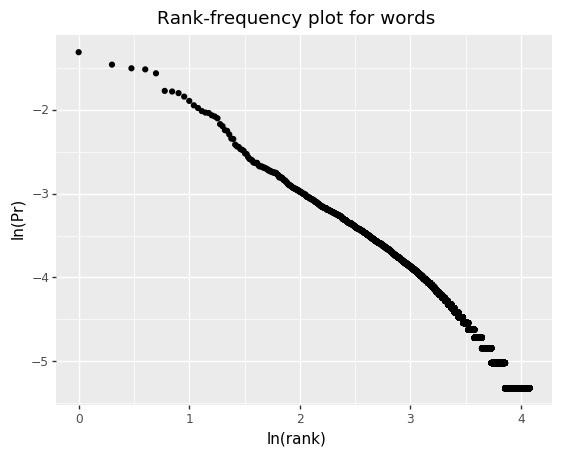

<ggplot: (8782884536482)>

In [9]:
(ggplot(df) 
 + geom_point(aes('ln(r)','ln(Pr)')) 
 + labs(title="Rank-frequency plot for words", x="ln(rank)")
)

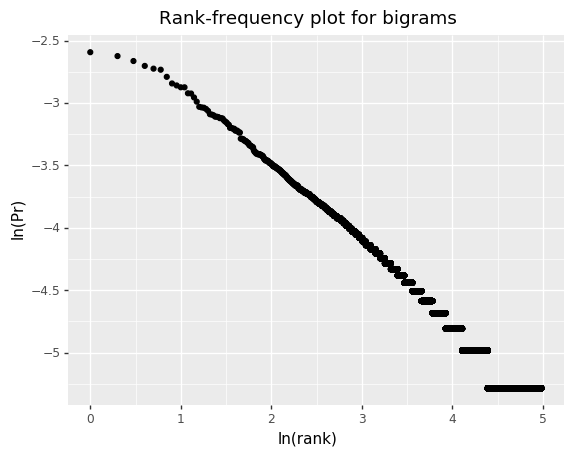

<ggplot: (-9223363253989614788)>

In [10]:
(ggplot(dfbi) 
 + geom_point(aes('ln(r)','ln(Pr)'))
 + labs(title="Rank-frequency plot for bigrams", x="ln(rank)")
)

### Tuning the parameter c

In this section let's tune the parameter c using the quality metric *RMSE* as a point of reference.

In [11]:
from math import inf, sqrt
from functools import reduce

def search_best_c(df, search_range):

    """Searchs for best c parameter for a collection.

    Fits a range of 'c' to predict ranking using probability
    and assesses each fit by using the metric RMSE, this func
    returns the best 'c' and the lowest 'RMSE'.

    :param obj df: Pandas dataframe with the collection data.

    :return: c parameter that yielded the lowest rmse 

    :rtype: float
    
    :return: lowest rmse encountered 

    :rtype: float
    """
    rmse = 0
    best_c = None
    N = df.shape[0]
    best_rmse = inf
    
    for c in search_range:
        rmse = df["r"] - (c / df["Pr"] )
        rmse = list(map(lambda x: pow(x,2), rmse))
        rmse = reduce(lambda x,y: x+y, rmse)
        rmse = sqrt(rmse / N)
        if rmse < best_rmse:
            best_rmse = rmse
            best_c = c

    return best_c, best_rmse

In [12]:
word_c, word_rmse = search_best_c(df, arange(1e-20, 1, 2.5e-3))

display(Markdown("***"))
display(Markdown("### Best parameter 'c'  for *el país* collection in terms of words"))
print("\n    c: {}".format(word_c))
print(" rmse: {}".format(word_rmse))
display(Markdown("***"))

***

### Best parameter 'c'  for *el país* collection in terms of words


    c: 0.0475
 rmse: 1363.464264091369


***

In [13]:
bi_c, bi_rmse = search_best_c(dfbi, arange(1e-20, 1, 2.5e-3))
display(Markdown("***"))
display(Markdown("### Best parameter 'c'  for *el país* collection in terms of bigrams"))
print("\n    c: {}".format(bi_c))
print(" rmse: {}".format(bi_rmse))
display(Markdown("***"))

***

### Best parameter 'c'  for *el país* collection in terms of bigrams


    c: 0.3075
 rmse: 18411.22041534236


***

### Compare predicted with actual

In [14]:
df["pred_r"] = (word_c / df["Pr"])
df["ln(pred_r)"] = df["pred_r"].apply(lambda x: log10(x))
df.head()

,Word,Freq.,r,ln(r),Pr,ln(Pr),Pr(%),r * Pr,pred_r,ln(pred_r)
0,de,10194,1,0.000000,0.048613,-1.313246,4.861323,0.048613,0.977100,-0.010061
1,a,7250,2,0.301030,0.034574,-1.461252,3.457386,0.069148,1.373870,0.137946
2,que,6552,3,0.477121,0.031245,-1.505216,3.124523,0.093736,1.520232,0.181910
3,o,6363,4,0.602060,0.030344,-1.517928,3.034393,0.121376,1.565387,0.194622
4,e,5708,5,0.698970,0.027220,-1.565106,2.722036,0.136102,1.745018,0.241800


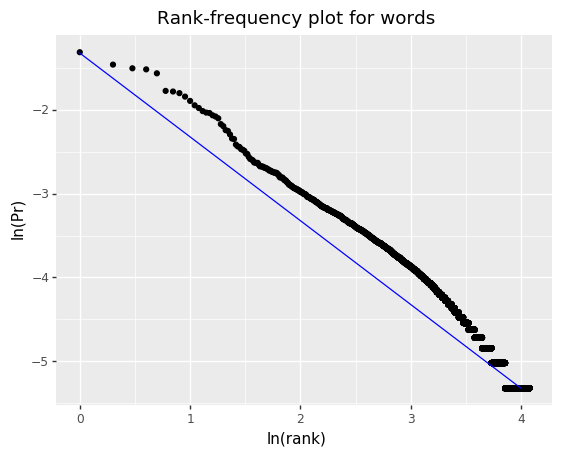

<ggplot: (-9223363253987881791)>

In [15]:
(ggplot(df) 
 + geom_point(aes('ln(r)','ln(Pr)')) 
 + geom_line(aes('ln(pred_r)','ln(Pr)'), color="blue") 
 + labs(title="Rank-frequency plot for words", x="ln(rank)")
)

* There's a substantial deviation from the actual ranking (black),  counterintuitive as it may be at the extremes the predicted (blue) and the actual ranking (black) come closer to each other.

In [16]:
dfbi["pred_r"] = (bi_c / dfbi["Pr"])
dfbi["ln(pred_r)"] = dfbi["pred_r"].apply(lambda x: log10(x))
dfbi.head()

,Bigram,Freq.,r,ln(r),Pr,ln(Pr),Pr(%),r * Pr,pred_r,ln(pred_r)
0,"(que, o)",493,1,0.000000,0.002554,-2.592823,0.255374,0.002554,120.411511,2.080668
1,"(com, o)",459,2,0.301030,0.002378,-2.623857,0.237762,0.004755,129.330882,2.111702
2,"(com, a)",419,3,0.477121,0.002170,-2.663456,0.217042,0.006511,141.677506,2.151301
3,"(o, que)",383,4,0.602060,0.001984,-2.702471,0.198394,0.007936,154.994452,2.190316
4,"(que, a)",364,5,0.698970,0.001886,-2.724568,0.188552,0.009428,163.084821,2.212414


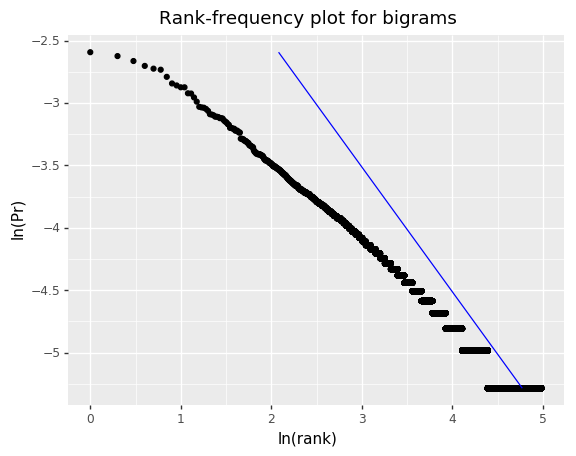

<ggplot: (-9223363253987847231)>

In [17]:
(ggplot(dfbi) 
 + geom_point(aes('ln(r)','ln(Pr)')) 
 + geom_line(aes('ln(pred_r)','ln(Pr)'), color="blue") 
 + labs(title="Rank-frequency plot for bigrams", x="ln(rank)")
)

* In the case of bigrams  the deviation is far more radical.

## Predicting Proportion

In [18]:
actual_nwords = df['Freq.'].value_counts()
actual_prop = df.groupby(['Freq.'])['Pr'].agg('sum')

df_prop = pd.DataFrame({'n':actual_prop.index, 'actual_#words':actual_nwords.values,
                        'actual_prop': actual_prop.values})

df_prop["pred_prop"] = df_prop["n"].apply(lambda n: (1 / (n *(n + 1))))

df_prop = df_prop[['n','pred_prop', 'actual_prop', 'actual_#words']]
df_prop.columns = ["Number of occurrences (n)", 'Predicted Proportion (1/n(n+1))',
                   'Actual Proportion', 'Actual Number of Words']

display(Markdown("***"))
display(Markdown("### Proportions of words occurring n times"))
display(HTML(df_prop.head(10).to_html(index=False)))
display(Markdown("***"))

***

### Proportions of words occurring n times

Number of occurrences (n),Predicted Proportion (1/n(n+1)),Actual Proportion,Actual Number of Words
1,0.500000,0.022747,4770
2,0.166667,0.016901,1772
3,0.083333,0.013763,962
4,0.050000,0.012151,637
5,0.033333,0.010897,457
6,0.023810,0.009957,348
7,0.017857,0.008846,265
8,0.013889,0.008393,220
9,0.011111,0.006610,168
10,0.009091,0.008012,154


***

In [19]:
actual_nbi = dfbi['Freq.'].value_counts()
actual_propbi = dfbi.groupby(['Freq.'])['Pr'].agg('sum')

df_propbi = pd.DataFrame({'n':actual_propbi.index, 'actual_#bigrams':actual_nbi.values,
                        'actual_propbi': actual_propbi.values})

df_propbi["pred_prop"] = df_propbi["n"].apply(lambda n: (1 / (n *(n + 1))))

df_propbi = df_propbi[['n','pred_prop', 'actual_propbi', 'actual_#bigrams']]
df_propbi.columns = ["Number of occurrences (n)", 'Predicted Proportion (1/n(n+1))',
                   'Actual Proportion', 'Actual Number of Bigrams']

display(Markdown("***"))
display(Markdown("### Proportions of bigrams occurring n times"))
display(HTML(df_propbi.head(10).to_html(index=False)))
display(Markdown("***"))

***

### Proportions of bigrams occurring n times

Number of occurrences (n),Predicted Proportion (1/n(n+1)),Actual Proportion,Actual Number of Bigrams
1,0.500000,0.369599,71351
2,0.166667,0.122704,11844
3,0.083333,0.067956,4373
4,0.050000,0.050598,2442
5,0.033333,0.037736,1457
6,0.023810,0.029402,946
7,0.017857,0.024258,669
8,0.013889,0.019352,467
9,0.011111,0.018275,392
10,0.009091,0.015436,298


***